<a href="https://colab.research.google.com/github/gmxavier/FAT0413150/blob/main/notebooks/05_01_Simultating_block_diagrams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating block diagrams

>N.B.: Parts of this notebook were taken from [here](https://github.com/alchemyst/Dynamics-and-Control/blob/master/Simulation/Blocksim.ipynb).

## Summary

`tbcontrol.blocksim` is a simple library for simulating block diagrams like this one.

Let's start with this feedback control loop taken from [here](https://sites.chemengr.ucsb.edu/~ceweb/faculty/seborg/teaching/SEM_2_slides/Chapter%2011%20(11-23-04).pdf).

![simple_feedback](http://apmonitor.com/che436/uploads/Main/block_diagram.png)

## Initializations

In [2]:
!pip install tbcontrol
from tbcontrol import blocksim 
import numpy # as we usual need some numerical gadgets
import matplotlib.pyplot as plt # in order to produce nice plots
%matplotlib inline

## Building a block diagram

We need to define objects representing each of the blocks. A common one is the LTI block, so the first block is

In [3]:
Km = blocksim.LTI('Km', 'xsp', 'xsptilde', (20-4)/(1-0))
Km

LTI: xsp →[ Km ]→ xsptilde

The control loop uses a PI controller, so

In [4]:
Gc = blocksim.PI('Gc', 'e', 'p', 5, 5)
Gc

PI: e →[ Gc ]→ p

In order to limit the controller output, we define also a limiter block as following, assuming a controller bias of 12 mA.

In [5]:
def limit(t, u):
    return numpy.clip(u, -4, 4)

Limiter = blocksim.AlgebraicEquation('Limiter', 'p', 'plimited', limit)

And the following blocks are

In [6]:
Kip = blocksim.LTI('Kip', 'plimited', 'pt', (15-3)/(20-12))
Kip

LTI: plimited →[ Kip ]→ pt

In [7]:
Gv = blocksim.LTI('Gv', 'pt', 'w2', (20-0)/(15-3), [1/60, 1])
Gv

LTI: pt →[ Gv ]→ w2

In [8]:
Vrho = 100 # kg
wbar = 10  # kg/min
w1bar = 5  # kg/min
xbar = 0.5 # mass fraction
tau1 = tau2 = Vrho/wbar # min
K1 = w1bar/wbar         # dimensionless
K2 = (1 - xbar)/wbar    # mass fraction/(kg/min)
Gd = blocksim.LTI('Gd', 'x1', 'xd', K1, [tau1, 1])
Gd

LTI: x1 →[ Gd ]→ xd

In [9]:
Gp = blocksim.LTI('Gp', 'w2', 'xu', K2, [tau2, 1])
Gp

LTI: w2 →[ Gp ]→ xu

In [10]:
Gm = blocksim.LTI('Gm', 'x', 'xm', (20-4)/(1-0))
Gm

LTI: x →[ Gm ]→ xm

Once we have the blocks, we can create a `Diagram`.

Sums are specified as a dictionary with the keys being the output signal and the values being a tuple containing the input signals. The leading + is compulsory.

The inputs come next and are specified as functions of time. `blocksim.step()` can be used to build a step function.

In [11]:
diagram = blocksim.Diagram([Km, Gc, Limiter, Kip, Gv, Gp, Gd, Gm], 
                           sums={'e': ('+xsptilde', '-xm'),
                                 'x': ('+xd', '+xu')}, 
                           inputs={'xsp': blocksim.step(size=0.1),
                                   'x1' : blocksim.step(starttime=60,size=0.1)})
diagram

LTI: xsp →[ Km ]→ xsptilde
PI: e →[ Gc ]→ p
AlgebraicEquation: p →[ Limiter ]→ plimited
LTI: plimited →[ Kip ]→ pt
LTI: pt →[ Gv ]→ w2
LTI: w2 →[ Gp ]→ xu
LTI: x1 →[ Gd ]→ xd
LTI: x →[ Gm ]→ xm

In the chunk of code above we specify an step change in the setpoint $x_{sp}$ at t = 0 min and a step change in the disturbance $x_1$ at t = 20 min. Both step changes have an amplitude of 0.1 mass fraction. 

`blocksim` is primarily focused on being able to simulate a diagram. The next step is to create a time vector and do the simulation.

The time vector also specifies the step size for integration. Since `blocksim` uses Euler integration internally you should choose a time step which is at least 10 times smaller than the smallest time constant of all the blocks. The timespan is of course dependent on what you are investigating.

In [12]:
ts = numpy.linspace(start=0, stop=120, num=120*600)

In [13]:
simulation_results = diagram.simulate(ts, progress=True)

  0%|          | 0/72000 [00:00<?, ?it/s]

The result of `simulate()` is a dictionary containing the simulation results.

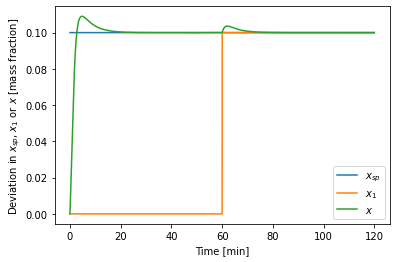

In [15]:
plt.plot(ts, simulation_results['xsp'], ts, simulation_results['x1'], ts, simulation_results['x'])
plt.xlabel('Time [min]')
plt.ylabel('Deviation in $x_{sp}$, $x_1$ or $x$ [mass fraction]')
plt.legend(['$x_{sp}$', '$x_1$', '$x$'])

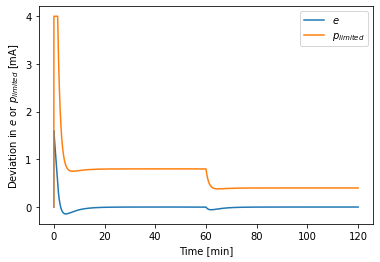

In [17]:
plt.plot(ts, simulation_results['e'], ts, simulation_results['plimited'])
plt.xlabel('Time [min]')
plt.ylabel('Deviation in $e$ or $p_{limited}$ [mA]')
plt.legend(['$e$', '$p_{limited}$'])

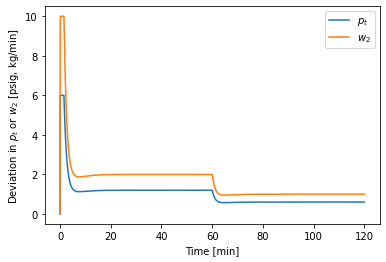

In [18]:
plt.plot(ts, simulation_results['pt'], ts, simulation_results['w2'])
plt.xlabel('Time [min]')
plt.ylabel('Deviation in $p_t$ or $w_2$ [psig, kg/min]')
plt.legend(['$p_t$', '$w_2$'])

Now let's try to simulate the control loop shown [here (Fig. 8-17)](https://udghoshna.files.wordpress.com/2013/06/136649035-process-systems-analysis-and-control-d-coughanowr-3rd-ed.pdf#page=202) 

In [19]:
Kc = 20
Kc = blocksim.LTI('Kc', 'Error', 'Q', Kc)
Kc

LTI: Error →[ Kc ]→ Q

In [20]:
A = 0.0714
A = blocksim.LTI('A', 'Q', 'out1', A)
A

LTI: Q →[ A ]→ out1

In [21]:
tau = 5
Tank = blocksim.LTI('Tank', 'out2', 'T', 1, [tau, 1])
Tank

LTI: out2 →[ Tank ]→ T

In [22]:
taum = 0.33
Thermocouple = blocksim.LTI('Thermocouple', 'T', 'Tm', 1, [taum, 1])
Thermocouple

LTI: T →[ Thermocouple ]→ Tm

In [23]:
diagram = blocksim.Diagram([Kc, A, Tank, Thermocouple], 
                           sums={'Error': ('+Tr', '-Tm'),
                                 'out2': ('+out1', '+Ti')}, 
                           inputs={'Tr': blocksim.step(size=5),
                                   'Ti' : blocksim.step(starttime=15,size=5)})
diagram

LTI: Error →[ Kc ]→ Q
LTI: Q →[ A ]→ out1
LTI: out2 →[ Tank ]→ T
LTI: T →[ Thermocouple ]→ Tm

In [24]:
ts = numpy.linspace(start=0, stop=15, num=15*100)

In [25]:
simulation_results = diagram.simulate(ts, progress=True)

  0%|          | 0/1500 [00:00<?, ?it/s]

With these `simulation_results` we can plot part of the graph shown [here (Fig. 8-18)](https://udghoshna.files.wordpress.com/2013/06/136649035-process-systems-analysis-and-control-d-coughanowr-3rd-ed.pdf#page=202).

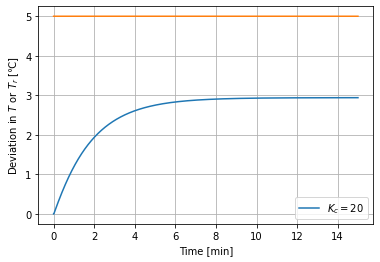

In [30]:
plt.plot(ts, simulation_results['T'], ts, simulation_results['Tr'])
plt.xlabel('Time [min]')
plt.ylabel('Deviation in $T$ or $T_r$ [℃]')
plt.legend(['$K_c = 20$'])
plt.grid()

Now we can add all chunks of code together and plot exactly the same graph shown [here (Fig. 12-5)](https://udghoshna.files.wordpress.com/2013/06/136649035-process-systems-analysis-and-control-d-coughanowr-3rd-ed.pdf#page=254).   

Remember that the change amplitude in the setpoint $T_r$ was 5℃, so this graph shows how the offset decreases with the increasing of $K_c$.

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

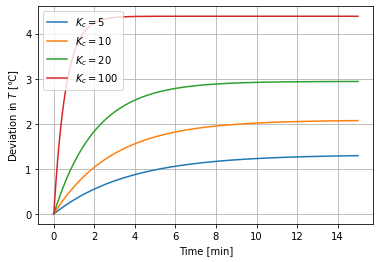

In [80]:
ts = numpy.linspace(start=0, stop=15, num=15*100)
def ex81(ts=ts, Kc=100, tau=5, taum=0, A = 0.0714, sizes=[5,5], starttimes=[0,15]):
  Kc = blocksim.LTI('Kc', 'Error', 'Q', Kc)
  A = blocksim.LTI('A', 'Q', 'out1', A)
  Tank = blocksim.LTI('Tank', 'out2', 'T', 1, [tau, 1])
  Thermocouple = blocksim.LTI('Thermocouple', 'T', 'Tm', 1, [taum, 1])
  diagram = blocksim.Diagram([Kc, A, Tank, Thermocouple], 
                           sums={'Error': ('+Tr', '-Tm'),
                                 'out2': ('+out1', '+Ti')}, 
                           inputs={'Tr': blocksim.step(size=sizes[0]),
                                   'Ti' : blocksim.step(starttime=starttimes[1],size=sizes[1])})
  return diagram.simulate(ts, progress=True)

Kcs = [5, 10, 20, 100]
for Kc in Kcs:
  simulation_results = ex81(Kc=Kc)
  plt.plot(ts, simulation_results['T'])
  plt.xlabel('Time [min]')
  plt.ylabel('Deviation in $T$ [℃]')

plt.legend(['$K_c = {0}$'.format(Kc) for Kc in Kcs])
plt.grid()